<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_2B_mmc_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 2, Session 2A

## Session 2A: MMCLAB Training

> **Training Goals**: <font color='green'>In this unit, we teach users basic workflows of creating mesh-based Monte Carlo (mmc) simulations in MATLAB/Octave environment. We will cover mesh generation, mesh-retessellation, plotting of output data in multi-layered and complex domains.</font>


# <font color='orange'> **Introduction**

MMC, or mesh-based Monte Carlo, is the result of [a series of productive research](https://mcx.space/wiki/index.cgi?Citation#MMC) since its initial proposal by our group [in 2010](https://www.osapublishing.org/boe/abstract.cfm?uri=boe-1-1-165).

A key feature of the solver is its improved accuracy and efficiency in modelling curved surfaces.
<div>
<img src="https://drive.google.com/uc?export=view&id=1bYCMs_hTu5wjrWZgA8Df-2k4ySY3SXGJ" width="600"/>
</div>

This is relevant for tissues such as brain:
<div>
<img src="https://drive.google.com/uc?export=view&id=1ocENfEbO1zAuWDyGxs621dkOAWryhY4C" width="800"/>
</div>


# <font color='orange'>Step 0: Setting up MCX and Octave environments within Google Colab</font>

> **You must rerun all cells in Step 0 in appearance order when you start a new session, or after reconnect to a runtime**

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Jupyter Notebook via "magic command" `%load_ext oct2py.ipython`

<font color='green'>If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and verify if it has already selected "GPU"; if not, please select the T4 GPU.</font>

**Please note**: MCX/MCXLAB is GPU-accelerated. This notebook by default requests an NVIDIA GPU. Howevever, when you click on the run-button for the below section, your browser may fail to allocate a GPU runtime and ask you if you want to continue with a non-GPU runtime. If you choose to proceed without GPU support, you will have to run the [section immediately following the next section](#mcx_setup_opencl) to install OpenCL-based MCXLAB (called mcxlabcl) and utilize the CPU to run the rest of the tutorials. The OpenCL version of MCXLAB will work for all examples, but will be substentially slower to run (this tutorial also reduces the photon numbers accordingly to lower the runtime).

In [20]:
#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! apt-get update && apt-get install octave jq libpocl2 pocl-opencl-icd libnvidia-compute-535   # install octave (a free matlab clone), jq and OpenCL runtimes
! python3 -m pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip MCXStudio
! rm -rf MCXStudio*
! curl https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip -O MCXStudio-linux-x86_64-nightlybuild.zip # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! cp -a "$PWD/MCXStudio/MCXSuite/mcx/bin/mcx" "/usr/local/bin"
! cp -a "$PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl" "/usr/local/bin"
! cp -a "$PWD/MCXStudio/MCXSuite/mmc/bin/mmc" "/usr/local/bin"
! cp -a "$PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex" "$PWD/MCXStudio/MATLAB/zmat/"

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && mv "/usr/local/bin/mcxcl" "/usr/local/bin/mcx"
! mcx -L

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
jq is already the newest version (1.6-2.1ubuntu3).
libpocl2 is already the newest version (1.8-3).
octave is already the newest version (6

### <font color='orange'>Init 2: Only need to run this once at the beginning</font>

In [21]:
%%octave
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                 % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);  % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                 % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']); % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);               % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);             % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                   % add path to zmat for data compression
addpath([pwd filesep 'MCXStudio/MATLAB/redbird-m/matlab']);       % add path to redbird-m
addpath([pwd filesep 'MCXStudio/MATLAB/hyperspectral_demo']);     % add path to hyperspectral_demo for exec 4

struct_levels_to_print(0);
print_struct_array_contents(0);

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

/opt/bin/nvidia-smi

### <font color='orange'>Init 3: Verify your environments</font>

---

In [22]:
%%octave

which mcx
which s2m
which zipmat

mmclab('gpuinfo')     % use this command to list supported CPU or GPU in octave
unix('mcx -L')        % use -L flag to list GPU in the command line

'mcx' is a function from the file /content/MCXStudio/MATLAB/mcxlab/mcx.mex

's2m' is a function from the file /content/MCXStudio/MATLAB/iso2mesh/s2m.m

'zipmat' is a function from the file /content/MCXStudio/MATLAB/zmat/zipmat.mex

Platform [0] Name NVIDIA CUDA

============ GPU device ID 0 [1 of 1]: Tesla T4  ============

 Device 1 of 1:		Tesla T4

 Compute units   :	40 core(s)

 Global memory   :	15835660288 B

 Local memory    :	49152 B

 Constant memory :	65536 B

 Clock speed     :	1590 MHz

 Compute Capacity:	7.5

 Stream Processor:	2560

 Vendor name    :	NVIDIA

 Auto-thread    :	163840

 Auto-block     :	64

Platform [1] Name Portable Computing Language

============ CPU device ID 1 [1 of 1]: pthread-Intel(R) Xeon(R) CPU @ 2.00GHz  ============

 Device 2 of 1:		pthread-Intel(R) Xeon(R) CPU @ 2.00GHz

 Compute units   :	2 core(s)

 Global memory   :	11461947392 B

 Local memory    :	524288 B

 Constant memory :	524288 B

 Clock speed     :	2000 MHz

 Vendor name    :	Unknown

 Auto-thread    :	128

 Auto-block     :	64

ans =

  2x1 struct array containing the fields:

    name

    id

    devcount

    major

    minor

    globalmem

    constmem

    sharedmem

    regcount

    clock

    sm

    core

    autoblock

    autothread

    maxgate

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans = 0

#  <font color='orange'> **Forward simulation in a layered slab**

## **Key objectives of the section:**

*   Meshing of simple layered domain
*   Key MMC inputs
*   Plotting MMC fluence and flux
*   MMC advantages and limitations





## **Mesh introduction/refresher**

###**What is a mesh?**
A mesh is a set of points in 3D space (**nodes**) and a series of relationships that attach them to one another.

- In MMC, the smallest units of our meshes are **tetrahedrons**, which we call **elements (elem)**.
    - Each tetrahedron elem has four **nodes**, one for each corner

- We can also describe a mesh using just its boundary surfaces, this is called a surface mesh.
    - surface meshes use triangular **faces** instead of tetrahedron
    
    ---
Above: left - a hemisphere solid mesh, right - a hemisphere surface mesh

To create and modify meshes, we use the Iso2Mesh library.

Several basic functions can be used to create an initial tetrahedral mesh, including:

- meshgrid5
- meshgrid6
- meshabox
- latticegrid
- meshasphere
- meshacylinder

Documentation of the library can be found here: https://iso2mesh.sourceforge.net/cgi-bin/index.cgi/.




## **Explaining mesh variables**:

A solid mesh can be created with two matrix variables:

 - The **node** variable stores all the coordinates of the points in the mesh
    - it is always a three column matrix

 - The **elem** variable stores the index of all the nodes making up a tetrahedron in each row.
    - it is usually a 4 column matrix (another column may be used to track materials)

---
One of the simplest meshes you can create is a cube or rectangular prism using the **meshgrid6** function. This function slices a rectangular prism into 6 equally sized tetrahedrons.

The code below shows a a mesh created with this function and the variables that describe it.


In [ ]:
#@title **Creating a simple lattice**
%%octave

x_coordinates = [0, 110];
y_coordinates = [0, 70];
z_coordinates = [0, 80];
[node, elem] = meshgrid6(x_coordinates, y_coordinates, z_coordinates);
figure;
caxis([0,10000]);
plotmesh(node, elem);

disp('The node values are:')
disp(node);
disp('Each row displays the coordinates of a node')
disp('-----------------------------------------------------------')
disp('The element values are:')
disp(elem);
disp('Each row displays the four IDs of nodes making up a tetrahedron')

In [ ]:
#@title **Setting properties of a simple lattice**
%%octave
disp('We can add a column to elements for optical properties:')
disp('Below, each tetrahedron is given its own material ID')
disp('------------------------------------------------------------')
disp('The element values are:')
elem_with_mat = [elem, [1:size(elem,1)]'];
disp(elem_with_mat);

figure;
plotmesh(node, elem_with_mat);
colormap('jet');
figure;
plotmesh(node, elem_with_mat);
view(-45,-45)

cb = colorbar;
colormap('jet');
ylabel(cb,'Material ID','FontSize',30,'Rotation',270);

##**Creating a 5-layered slab**

The meshgrid6 function is useful but as we can see, it does not allow us to create **multiple property-labelled regions** easily.

The **latticegrid** function allows us to create a **multi-layered slab** in two steps:




1. Specify dimensions for surface mesh

In [ ]:
%%octave

% thickness of each layer in mm
Thickness=[7.25,4.00,2.73,3.29,4.23];

% prepare simulation mesh (a five layered slab of 50mm x 50mm x 50mm):
% prepares a surface-only mesh:
x_bounds = [0 50];
y_bounds = [0 50];
z_layer_heights = [0 Thickness(1,1) sum(Thickness(1,1:2)) sum(Thickness(1,1:3)) sum(Thickness(1,1:4)) 50];
[nodes,faces]=latticegrid(x_bounds, y_bounds, z_layer_heights);


2. Convert the surface mesh to a solid mesh

In [ ]:
%%capture
%%octave
% prepares interior tetrahedrons for that mesh:
% max_volume is very important and determines our mesh density
% dramatically impacts performance:
max_volume = 1000;

[nodes,elems]=surf2mesh(nodes,faces,[],[],1,max_volume,[1 1 4;1 1 9;1 1 12;1 1 14.5;1 1 25]);


Display key info and plot the mesh:

In [ ]:
%%octave
% display the size of the mesh
disp('Size of the node matrix (rows) (columns):');
disp(size(nodes));
disp('Size of the element matrix (rows) (columns):');
disp(size(elems));

% plot the tetrahedral mesh to verify it is correct:
plotmesh(nodes, elems);
cb = colorbar;
colormap('jet');
ylabel(cb,'Material ID','FontSize',30,'Rotation',270);


## **Preparing MMC inputs**

For the MMC simulation, we have to create a config struct.
This struct can be named anything and will contain a series of settings and simulation parameters as fields.

The bare essential fields are:
- a mesh with nodes and elements
- a list of properties for all element IDs
- a source position and direction
- Time gates and steps (in seconds)
- number of photons

Delete any existing config variable:

In [ ]:
%%octave
clear cfg_mmc

Set the mesh for the simulation:

In [ ]:
%%octave
% set the config values to the mesh variables
cfg_mmc.node=nodes;
cfg_mmc.elem=elems;


Set the medium properties for background (air) and all 5 layers

In [ ]:
%%octave
% set the medium properties:
% labeling, row 1-air,2-scalp,3-skull,4-csf,5-gray matter,6-white matter
cfg_mmc.prop=[0,0,1,1;
              0.019, 7.8, 0.95, 1.37;
              0.019, 7.8, 0.95, 1.37;
              0.004, 0.009, 0.95, 1.37;
              0.02, 9.0, 0.95, 1.37;
              0.08, 10.9, 0.95, 1.37];


Set the number of photons:
(More = slower but less noisy results)

In [ ]:
%%octave
% set the number of photons
number_of_photons=100000 # @param {type:"slider", min:0, max:100000, step:100}
cfg_mmc.nphoton=number_of_photons;

Set the source position and direction:

In [ ]:
%%octave
% set the source position and direction:
cfg_mmc.srcpos=[25, 25, 0];
cfg_mmc.srcdir=[0, 0, 1];


Set the time gates and time steps:

In [ ]:
%%octave
% set the time bounds of the simulation in seconds:
cfg_mmc.tstart=0;
cfg_mmc.tend=5e-9;
cfg_mmc.tstep=5e-9;

% while we're at it, set the output to fluence,
% which is flux integrated by the time step
cfg_mmc.outputtype='fluence';

Choose a method for storing fluence:

In [ ]:
%%octave
MMC_method = "grid" # @param ["elem", "grid"]
cfg_mmc.method = MMC_method;

In [ ]:
%%octave
%Set the MMC random seed
seed = 2433243 # @param
cfg_mmc.seed = seed;

##**Run MMC simulation**

Quick final plot of our source and domain to make sure it's set up right

In [ ]:
%%octave
% we can plot the source position and direction
% to verify it is in the location on the mesh:
figure;
hold on;
plotmesh(nodes, elems);
scatter3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3), 500, 'MarkerFaceColor', 'r');
quiver3(cfg_mmc.srcpos(1), cfg_mmc.srcpos(2), cfg_mmc.srcpos(3),
        cfg_mmc.srcdir(1), cfg_mmc.srcdir(2), cfg_mmc.srcdir(3), 'MaxHeadSize', 44, 'Color', 'r', 'MarkerFaceColor', 'r');
view(-45,-45)

Run the simulation

In [ ]:
%%octave

% this sets up a progress bar and timer
cfg_mmc.debuglevel='TP';

% picks which gpu to run on, by setting ones or zeros.
% if you had three GPUs and you wanted to use all three, you would do:
% cfg_mmc.gpuid='111';
% if you had three GPUs and wanted to use the last two, you would do:
% cfg_mmc.gpuid='011';

% we currently only have one GPU:
cfg_mmc.gpuid='1';

fluence = mmclab(cfg_mmc);

## **MMC outputs and plotting**

MMC has two output types for fluence:

---

<div>
<img src="https://drive.google.com/uc?export=view&id=1nAMUSKVxMhcTbQ7ngN5iLk4jnBCbX84p" width="700"/>
</div>

---

<div>
<img src="https://drive.google.com/uc?export=view&id=1M1GHzWuY7-DKhRMgmrEBfID3lO9hM8vS" width="700"/>
</div>

<div>
<img src="https://drive.google.com/uc?export=view&id=1yDFZAhZJYPOX2cXnxZLKAKfE939Lcwx8" width="700"/>
</div>

---


Grid based simulations tend to be more efficient, but they may lack precision if you are interested in fine features on surfaces (by default the grid is made of 1mm^3 cubes)



Create a 2D set of coordinates for plotting:

In [ ]:
%%octave
% distance along the x-axis for the plane containing
% source and detectors
cross_section_srcdist = 25;

% define a plane using cross section srcplane:
cutting_plane = [cross_section_srcdist 0 0;cross_section_srcdist 1 0;cross_section_srcdist 0 1];

% vector of y-coorinates for the cross section
% note that our slab is 50mm wide
% if we want to plot fluence values at the center of each 1mm cube,
% we would start at 0.5 and go to 49.5 with 50 steps
cubesize = 1; % cube of 1mm x 1mm x 1mm

y_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% vector of z-coordinates for the cross section
% same as y-coordinates but the height of the slab is 50mm
z_vals = linspace(0+cubesize/2, 50-cubesize/2, 50);

% make a grid of coordinates for all fluence values in the cross section
[yy,zz]=meshgrid(y_vals,z_vals);

Obtain fluence values for a crosssection of the mesh, interpolate them to the grid

In [ ]:
%%octave
if(strcmp(cfg_mmc.method, 'elem'))
    % qmeshcut gets the intersections of all mesh edges and a plane
    % as a set of coordinate points and a set of interpolated values
    [cutpos,cutvalue,~]=qmeshcut(cfg_mmc.elem(:,1:4),cfg_mmc.node,fluence.data,cutting_plane);

    plottable_fluence_data=griddata(cutpos(:,2),cutpos(:,3),cutvalue,yy,zz);
end

if(strcmp(cfg_mmc.method, 'grid'))
    % plot a slice of the output grid nearest to the source plane
    % squeeze gets rid of a one-value dimension to the matrix
        plottable_fluence_data = squeeze(fluence.data(25, 1:50, 1:50));
        plottable_fluence_data = rot90(plottable_fluence_data, -1);
end

% we take the absolute value because arbitrarily small fluence
% may be recorded as negative values
[yy_plot,zz_plot]=meshgrid(1:(50),1:(50));
contourf(yy_plot,zz_plot,log10(abs(plottable_fluence_data)),'linewidth',5,'linestyle','-','DisplayName','Diffusion');
axis equal;
title('Fluence of a 5-layered slab')



**Why use MMC over MCX?**

As we saw in this section, MMC can be used to define and simulate layers with intermediate thicknesses with differences on the order of hundredths of a milimeter.

In the next section we will use MMC to simulate light travelling through a head model with curved boundaries.

#<font color='orange'>**Forward simulation in a brain atlas**

## **Key objectives of the section:**

*   Loading a pre-made mesh
*   Meshing and adding an inclusion
*   Plotting cross sections of a complex mesh

###**Prepare configuration**

Clear all previously created variables

In [ ]:
%%octave
clear;

Load the atlas mesh

In [ ]:
%%octave
load('MCXStudio/MATLAB/mmclab/example/head_atlas.mat');
node = double(node);
elem = double(elem);
property_IDs = double(prop);
cfg.node=node;
cfg.elem=elem;

% set the IDs for the properties of every element
cfg.elem(:,5)=property_IDs;

Set the optical properties (absorption coefficient (1/mm), scattering coefficient (1/mm), anisotrophy, refractive index)

In [ ]:
%%octave
%% prepare cfg for MMCLAB simulation

% medium labels: row 0-ambient air,
%                row 1-air cavities,
%                row 2-scalp,
%                row 3-skull,
%                row 4-csf,
%                row 5-gray matter,
%                row 6-white matter

cfg.prop=[0,0,1,1;
          0,0,1,1;
          0.019 7.8 0.89 1.37;
          0.019 7.8 0.89 1.37;
          0.004 0.009 0.89 1.37;
          0.02 9.0 0.89 1.37;
          0.08 40.9 0.84 1.37];

Choose how to store and output fluence (on a 3D grid or on nodes):

In [ ]:
%%octave
% store all output fluence as a 3D voxel grid
cfg.method='grid'; %DMMC mode

Choose how many photons to simulate:

In [ ]:

%%octave
cfg.nphoton=1e5; %takes ~240s on Intel i7-8700K(12 threads)

Set up the source:

In [ ]:
%%octave
% light source
cfg.srctype='pencil';
cfg.srcdir=[-0.5086,-0.1822,-0.8415]; %inward-pointing source
cfg.srcpos=[133.5370,90.1988,200.0700]; %pencil beam source placed at EEG 10-5 landmark:"C4h"
    cfg.srcpos=cfg.srcpos+0.001*cfg.srcdir; %ensure source is inside the mesh


Set up detectors:

In [ ]:
%%octave
cfg.detpos = [140, 90.5, 194, 1.5;
              150, 90.5, 182, 1.5]; % detector position


Set up time windows:

In [ ]:
%%octave
% time windows
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-10;

###**Run Atlas-based Simulation**

In [ ]:
%%octave
% allow calculations of reflection
cfg.isreflect=1;
% show a progress bar and timer
cfg.debuglevel='TP';
%% run mmc simulation
[flux, detected_photons]=mmclab(cfg);

### **Plot fluence cross section**

In [ ]:
%%octave
%% post-simulation data processing and visualization

% convert flux output to fluence
fluences = flux.data*cfg.tstep;
%sum the fluence over all time gates
fluences=sum(fluences,4);

% coronal plane selected for fluence plot
y_plane=90.5;

% account for spatial offset between the coordinate origins of the output grid and the mesh
starting_corner_of_domain=min(cfg.node); %starting location of the output grid
DMMC_voxel_origin=starting_corner_of_domain+0.5; %centroid of the 1st cube of the output grid

output_grid_dimensions=size(fluences);

% get the plane in the y-direction closest to the coordinates we want a cross section of
nearest_grid_plane = ceil(y_plane-starting_corner_of_domain(1,2));
CWfluence_DMMC=fluences(:,nearest_grid_plane,:);
% get rid of extra dimensions to the cross section matrix
CWfluence_DMMC=squeeze(CWfluence_DMMC);

% get meshgrid variables to describe coordinates of the cross section for plotting
[xx,zz]=meshgrid(DMMC_voxel_origin(1,1):(DMMC_voxel_origin(1,1)+output_grid_dimensions(1,1)-1),DMMC_voxel_origin(1,3):(DMMC_voxel_origin(1,3)+output_grid_dimensions(1,3)-1));


Plot the fluence cross section:

In [ ]:
%%octave

% this secion takes the fluence values for a cross section and plots them as a contour plot
clines=-20:0.5:0;
contourf(xx,zz,log10(abs(CWfluence_DMMC')),clines,'linestyle','--','linewidth',1.5,'DisplayName','DMMC');
hold on;axis equal;
colorbar('EastOutside');

%------------------------------------------------------------------------------
                         This section just plots the tissue boundaries
%------------------------------------------------------------------------------
plane=[0 y_plane 0; 0 y_plane 1; 1 y_plane 0];
label=unique(prop);
face=[];
for i=1:2:size(label,1)
    newface=volface(cfg.elem(prop==label(i),1:4));
    face=[face;newface];
end
[cutpos,cutvalue,cutedges]=qmeshcut(face(:,1:3),node,node(:,1),plane);
[cutpos,cutedges]=removedupnodes(cutpos,cutedges);
cutloop=extractloops(cutedges);
[nanidx]=find(isnan(cutloop));

for i=1:size(nanidx,2)
    if(i==9)
        continue;
    end
    if(i==1)
        plot(cutpos(cutloop(1:(nanidx(i)-1)),1),cutpos(cutloop(1:(nanidx(i)-1)),3),'linestyle','--','color','k','LineWidth',1.25,'HandleVisibility','off');
    elseif(i==2)
        plot(cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),1),cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),3),'linestyle','--','color','k','LineWidth',1.25,'HandleVisibility','off');
    else
        plot(cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),1),cutpos(cutloop((nanidx(i-1)+1):(nanidx(i)-1)),3),'linestyle','--','color','k','LineWidth',1.25,'HandleVisibility','off');
    end
end
%------------------------------------------------------------------------------
            This section plots the source and detector positions
%------------------------------------------------------------------------------
plot(cfg.srcpos(1,1),cfg.srcpos(1,3),'o','MarkerEdgeColor','r','MarkerFaceColor','r','MarkerSize',10,'DisplayName','source');
plot(cfg.detpos(1,1),cfg.detpos(1,3),'o','MarkerEdgeColor','b','MarkerFaceColor','b','MarkerSize',10,'DisplayName','detector');
plot(cfg.detpos(2,1),cfg.detpos(2,3),'o','MarkerEdgeColor','b','MarkerFaceColor','b','MarkerSize',10,'DisplayName','detector');
set(gca,'ylim', [160 225]);ylabel('z [mm]');
set(gca,'xlim', [80 165]);xlabel('x [mm]');

#<font color='orange'> **Simulation with a Pattern Source:**

Produce slab mesh with property IDs

layercount = 2

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

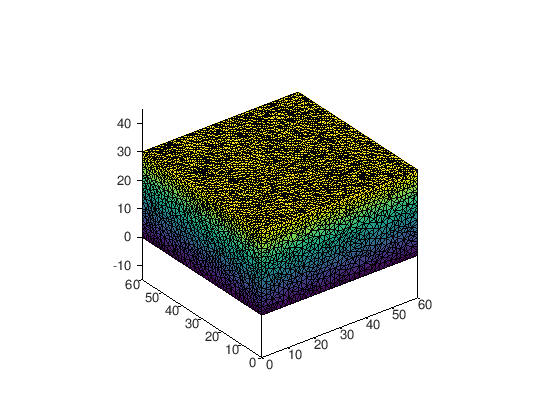

In [54]:
%%octave

clear cfg;
clear all;

%% 2-layer mesh model

layercount= 2 # @param {type:"slider", min:2, max:3, step:1}

if(layercount==2)
    [node,face,c0]=latticegrid([0 60],[0 60],[0 25 30]);
    c0(:,4)=[2;1];   % maximum element size for bottom (label 1) and top (label 2) layers

    % simulate the optical properties of skull and gray-matter of a human brain model
    % see http://mcx.sourceforge.net/cgi-bin/index.cgi?MMC/Colin27AtlasMesh
    cfg.prop=[0 0 1 1;0.02 9.0, 0.89 1.37;0.019 7.8 0.89 1.37];
else
    [node,face,c0]=latticegrid([0 60],[0 60],[0 20 25 30]); % if you like a 3-layer model
    c0(:,4)=[2;2;1];
    cfg.prop=[0 0 1 1;0.02 9.0, 0.89 1.37;0.004 0.009, 0.89 1.37;0.019 7.8 0.89 1.37];
end
[cfg.node,cfg.elem]=surf2mesh(node,face,[],[],1,[],c0);

cfg.elemprop=cfg.elem(:,5);
cfg.elem=cfg.elem(:,1:4);

% plot the domain to check it
figure;
plotmesh(cfg.node,cfg.elem);

Set up pattern source

In [55]:


%%octave

%% add source and retessellate mesh

cfg.srctype='fourier';      % define an SFDI source
cfg.srcpos=[10 10 35];      % one corner of the illumination area
% wave number in the x-dir
wavenum_x = 0 # @param {type:"slider", min:0, max:5, step:1}
% wave number in the y-dir
wavenum_y = 3 # @param {type:"slider", min:0, max:5, step:1}


% phase offset in the x-dir, must < 2pi
xphase = pi/3 # @param ["pi/3", "pi/2", "0", "pi"] {type:"raw"}
% phase offset in the x-dir, must < 2pi
yphase = 0 # @param ["pi/3", "pi/2", "0", "pi"] {type:"raw"}

cfg.srcparam1=[40 0 0 wavenum_x+xphase/(2*pi)];
cfg.srcparam2=[0 40 0 wavenum_y+yphase/(2*pi)];
cfg.srcdir=[0 0 -1];

%% line 24-31 could possibly be deleted and replaced by built-in one-step command
srcdef=struct('srctype',cfg.srctype,'srcpos',cfg.srcpos,'srcdir',cfg.srcdir,...
    'srcparam1',cfg.srcparam1,'srcparam2',cfg.srcparam2);

[cfg.node,cfg.elem] = mmcaddsrc(cfg.node,[cfg.elem cfg.elemprop],...
    mmcsrcdomain(srcdef,[min(cfg.node);max(cfg.node)]));

wavenum_x = 0

wavenum_y = 3

xphase = 1.0472

yphase = 0

refining the input mesh ...

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

mesh refinement is complete

Set up other config settings and run simulation

In [65]:
%%octave

%% other simulation information

cfg.nphoton=3e3;
cfg.seed=1648335518;

cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=1e-10;

cfg.debuglevel='TP';
cfg.isreflect=1;
cfg.detpos=[30 30 0 2]; % detector position
cfg.method='elem';

%% mmc simulation

layer=mmclab(cfg);
layer=layer.data;
layercw=sum(layer,2);

Launching MMCLAB - Mesh-based Monte Carlo for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mmc.prop=2;

mmc.nn=21664;

mmc.elem=[130206,4];

mmc.ne=130206;

mmc.srctype='fourier';

mmc.srcpos=[10 10 35];

mmc.srcparam1=[40 0 0 0.166667];

mmc.srcparam2=[0 40 0 3];

mmc.srcdir=[0 0 -1 0];

mmc.nphoton=3000;

mmc.seed=1648335518;

mmc.tstart=0;

mmc.tend=5e-09;

mmc.tstep=1e-10;

mmc.debuglevel='TP';

mmc.isreflect=1;

mmc.detnum=1;

mmc.method='elem';

mmc.facenb=[130206,4];

mmc.evol=130206;

mmc.e0=127569;

	done	60

simulating ...

###############################################################################

#                     Mesh-based Monte Carlo (MMC) - OpenCL                   #

#          Copyright (c) 2010-2024 Qianqian Fang <q.fang at neu.edu>          #

#              https://mcx.space/#mmc  &  https://neurojson.io/               #

#                                                                             #

#Computational Optics & Translational Imaging (COTI) Lab  [http://fanglab.org]#

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::efc749$v2024.2 $Date::2024-06-09 15:58:33 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [MMC-OpenCL] compiled with OpenCL version [1]

- compiled with: [RNG] xorshift128+ RNG [Seed Length] 4

initializing streams ...	init complete : 0 ms

Building kernel with option: -cl-mad-enable -DMCX_USE_NATIVE -DMCX_SIMPLIFY_BRANCH -DMCX_VECTOR_INDEX -DMCX_SRC_FOURIER   -DUSE_ATOMIC -DMCX_DO_REFLECTION -DUSE_BLBADOUEL -DUSE_NVIDIA_GPU

build program complete : 10 ms

- [device 0(1): Tesla T4] threadph=0 oddphotons=3000 np=3000.0 nthread=163840 nblock=64 repetition=1

set kernel arguments complete : 11 ms 3

lauching mcx_main_loop for time window [0.0ns 5.0ns] ...

simulation run# 1 ...

Progress: [>                                                             ]   0%Progress: [=================================>                            ]  55%Progress: [==============================================================] 100%

kernel complete:  	276 ms

retrieving flux ... 	transfer complete:        317 ms

normalizing raw data ...	simulated 3000 photons (3000) with 1 devices (ray-tet 3102067)

MCX simulation speed: 11.36 photon/ms

total simulated energy: 1493.48	absorbed: 47.00858%

(loss due to initial specular reflection is excluded in the total)

	done	773

Plot widefield results

cross_section_zdist = 30

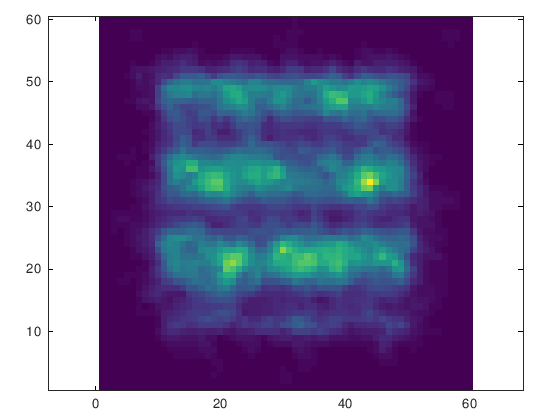

In [67]:
%%octave

% plot simulated photon profiles

hold on;

% vector of x-coorinates for the cross section
% note that our slab is 60mm wide and we are plotting 1mm wide pixels
cubesize = 1;

x_vals = linspace(0+cubesize/2, 60-cubesize/2, 60);

% vector of y-coordinates for the cross section
% same as x-coordinates but the height of the slab is 60mm
y_vals = linspace(0+cubesize/2, 60-cubesize/2, 60);

% make a grid of coordinates for all fluence values in the cross section
[xx, yy]=meshgrid(x_vals,y_vals);

% distance along the z-axis for the plane containing
% source and detectors
cross_section_zdist = 30 # @param {type:"slider", min:0, max:30, step:0.5}

% define a plane using cross section srcplane:
cutting_plane = [1 0 cross_section_zdist;0 1 cross_section_zdist;0 0 cross_section_zdist];

% qmeshcut gets the intersections of all mesh edges and a plane
% as a set of coordinate points and a set of interpolated values
[cutpos,cutvalue,~]=qmeshcut(cfg.elem(:,1:4),cfg.node,layercw, cutting_plane);

plottable_fluence_data=griddata(cutpos(:,1),cutpos(:,2),(cutvalue),xx,yy);

imagesc(plottable_fluence_data)
box on;
axis equal
%view(-56, 22);